In [ ]:

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/CECS551_Fianl_Project_Dataset/

/content/drive/My Drive/CECS551_Fianl_Project_Dataset


In [ ]:
!pip install xgboost
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 16.8 MB/s 


In [ ]:
import pandas as pd
import chardet
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import xgboost
import shap
from xgboost.sklearn import XGBRegressor



import warnings
warnings.filterwarnings("ignore")

stores = pd.read_csv("CECS551_dataset_01/stores.csv")
test = pd.read_csv("CECS551_dataset_01/test.csv")
train = pd.read_csv("CECS551_dataset_01/train.csv")

store_01 = pd.read_csv("CECS551_dataset_01/store_features/store_01.xlsx")
store_02 = pd.read_excel("CECS551_dataset_01/store_features/store_02.xlsx")
store_03 = pd.read_excel("CECS551_dataset_01/store_features/store_03.xlsx")
store_04 = pd.read_excel("CECS551_dataset_01/store_features/store_04.xlsx")
store_05 = pd.read_excel("CECS551_dataset_01/store_features/store_05.xlsx")
store_06 = pd.read_excel("CECS551_dataset_01/store_features/store_06.xlsx")
store_07 = pd.read_excel("CECS551_dataset_01/store_features/store_07.xlsx")
store_08 = pd.read_excel("CECS551_dataset_01/store_features/store_08.xlsx")
store_09 = pd.read_excel("CECS551_dataset_01/store_features/store_09.xlsx")
store_10 = pd.read_excel("CECS551_dataset_01/store_features/store_10.xlsx")
ind_stores = [store_01,store_02,store_03,store_04,store_05,store_06,store_07,store_08,store_09,store_10]
combined_stores = pd.concat(ind_stores)

In [ ]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
# Niti section BEGINS
#co-relation 
import seaborn as sns
import matplotlib.pyplot as plt

combined_stores_shap = combined_stores.head()
combined_stores_shap["datetime"] = pd.to_datetime(combined_stores_shap["Date"])
combined_stores_shap = combined_stores_shap.drop(columns=['Date'])
combined_stores_shap

train_data = train.loc[train['Store'] <= 10].copy()

train_data = train_data.merge(train_data, how='left').merge(stores, how='left')

#train_data = train_data.drop(columns = ['Weekly_Sales'])
train_data["datetime"] = pd.to_datetime(train_data["Date"])
train_data = train_data.drop(columns=['Date'])
train_data_expanded = pd.merge(train_data, combined_stores_shap,  how='left', left_on=['Store','IsHoliday','datetime'], right_on = ['Store','IsHoliday','datetime'])
train_data_expanded = train_data_expanded.fillna(0)
train_data_expanded['IsHoliday'] = train_data_expanded['IsHoliday'].astype('str').map({'True':0,'False':1})
train_data_expanded['Type'] = train_data_expanded['Type'].astype('str').map({'A':0,'B':1,'C':2})
train_data_expanded

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,datetime,Temperature,gas_price,discount_promotional,discount_clearance,discount_damaged_good,discount_competitive,CPI,Unemployment
0,1,1,24924.50,1,0,151315,2010-02-05,59.33,3.360,9667.50,268.29,0.60,8368.15,223.659114,6.833
1,1,1,46039.49,0,0,151315,2010-02-12,51.65,3.409,8687.47,1594.87,2.20,2144.87,223.753643,6.833
2,1,1,41595.55,1,0,151315,2010-02-19,52.39,3.510,2706.87,3128.74,1.88,2396.68,223.917015,6.833
3,1,1,19403.54,1,0,151315,2010-02-26,60.12,3.555,6129.28,1802.84,0.00,301.48,224.132020,6.833
4,1,1,21827.90,1,0,151315,2010-03-05,61.65,3.630,3552.58,601.32,0.00,2666.22,224.347025,6.833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97834,10,98,22.34,1,1,126512,2012-09-28,0.00,0.000,0.00,0.00,0.00,0.00,0.000000,0.000
97835,10,98,789.38,1,1,126512,2012-10-05,0.00,0.000,0.00,0.00,0.00,0.00,0.000000,0.000
97836,10,98,477.24,1,1,126512,2012-10-12,0.00,0.000,0.00,0.00,0.00,0.00,0.000000,0.000
97837,10,98,578.46,1,1,126512,2012-10-19,0.00,0.000,0.00,0.00,0.00,0.00,0.000000,0.000


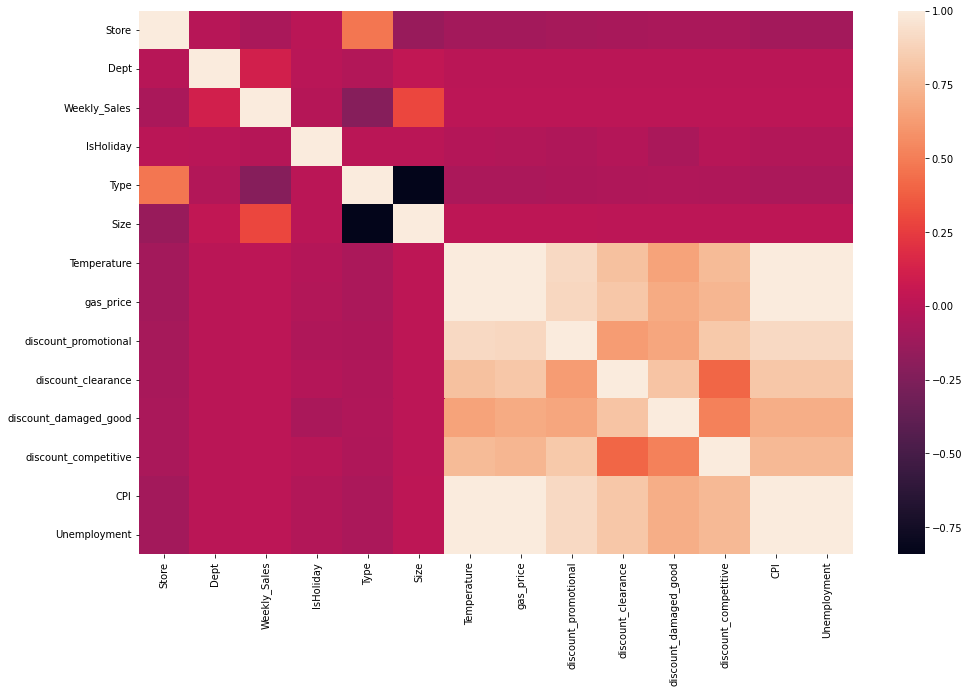

In [ ]:
#Heatmap
corr_df = train_data_expanded.drop(columns = ["datetime"])

plt.figure(figsize=(16,10))
correlation = corr_df.corr()
sns.heatmap(correlation);

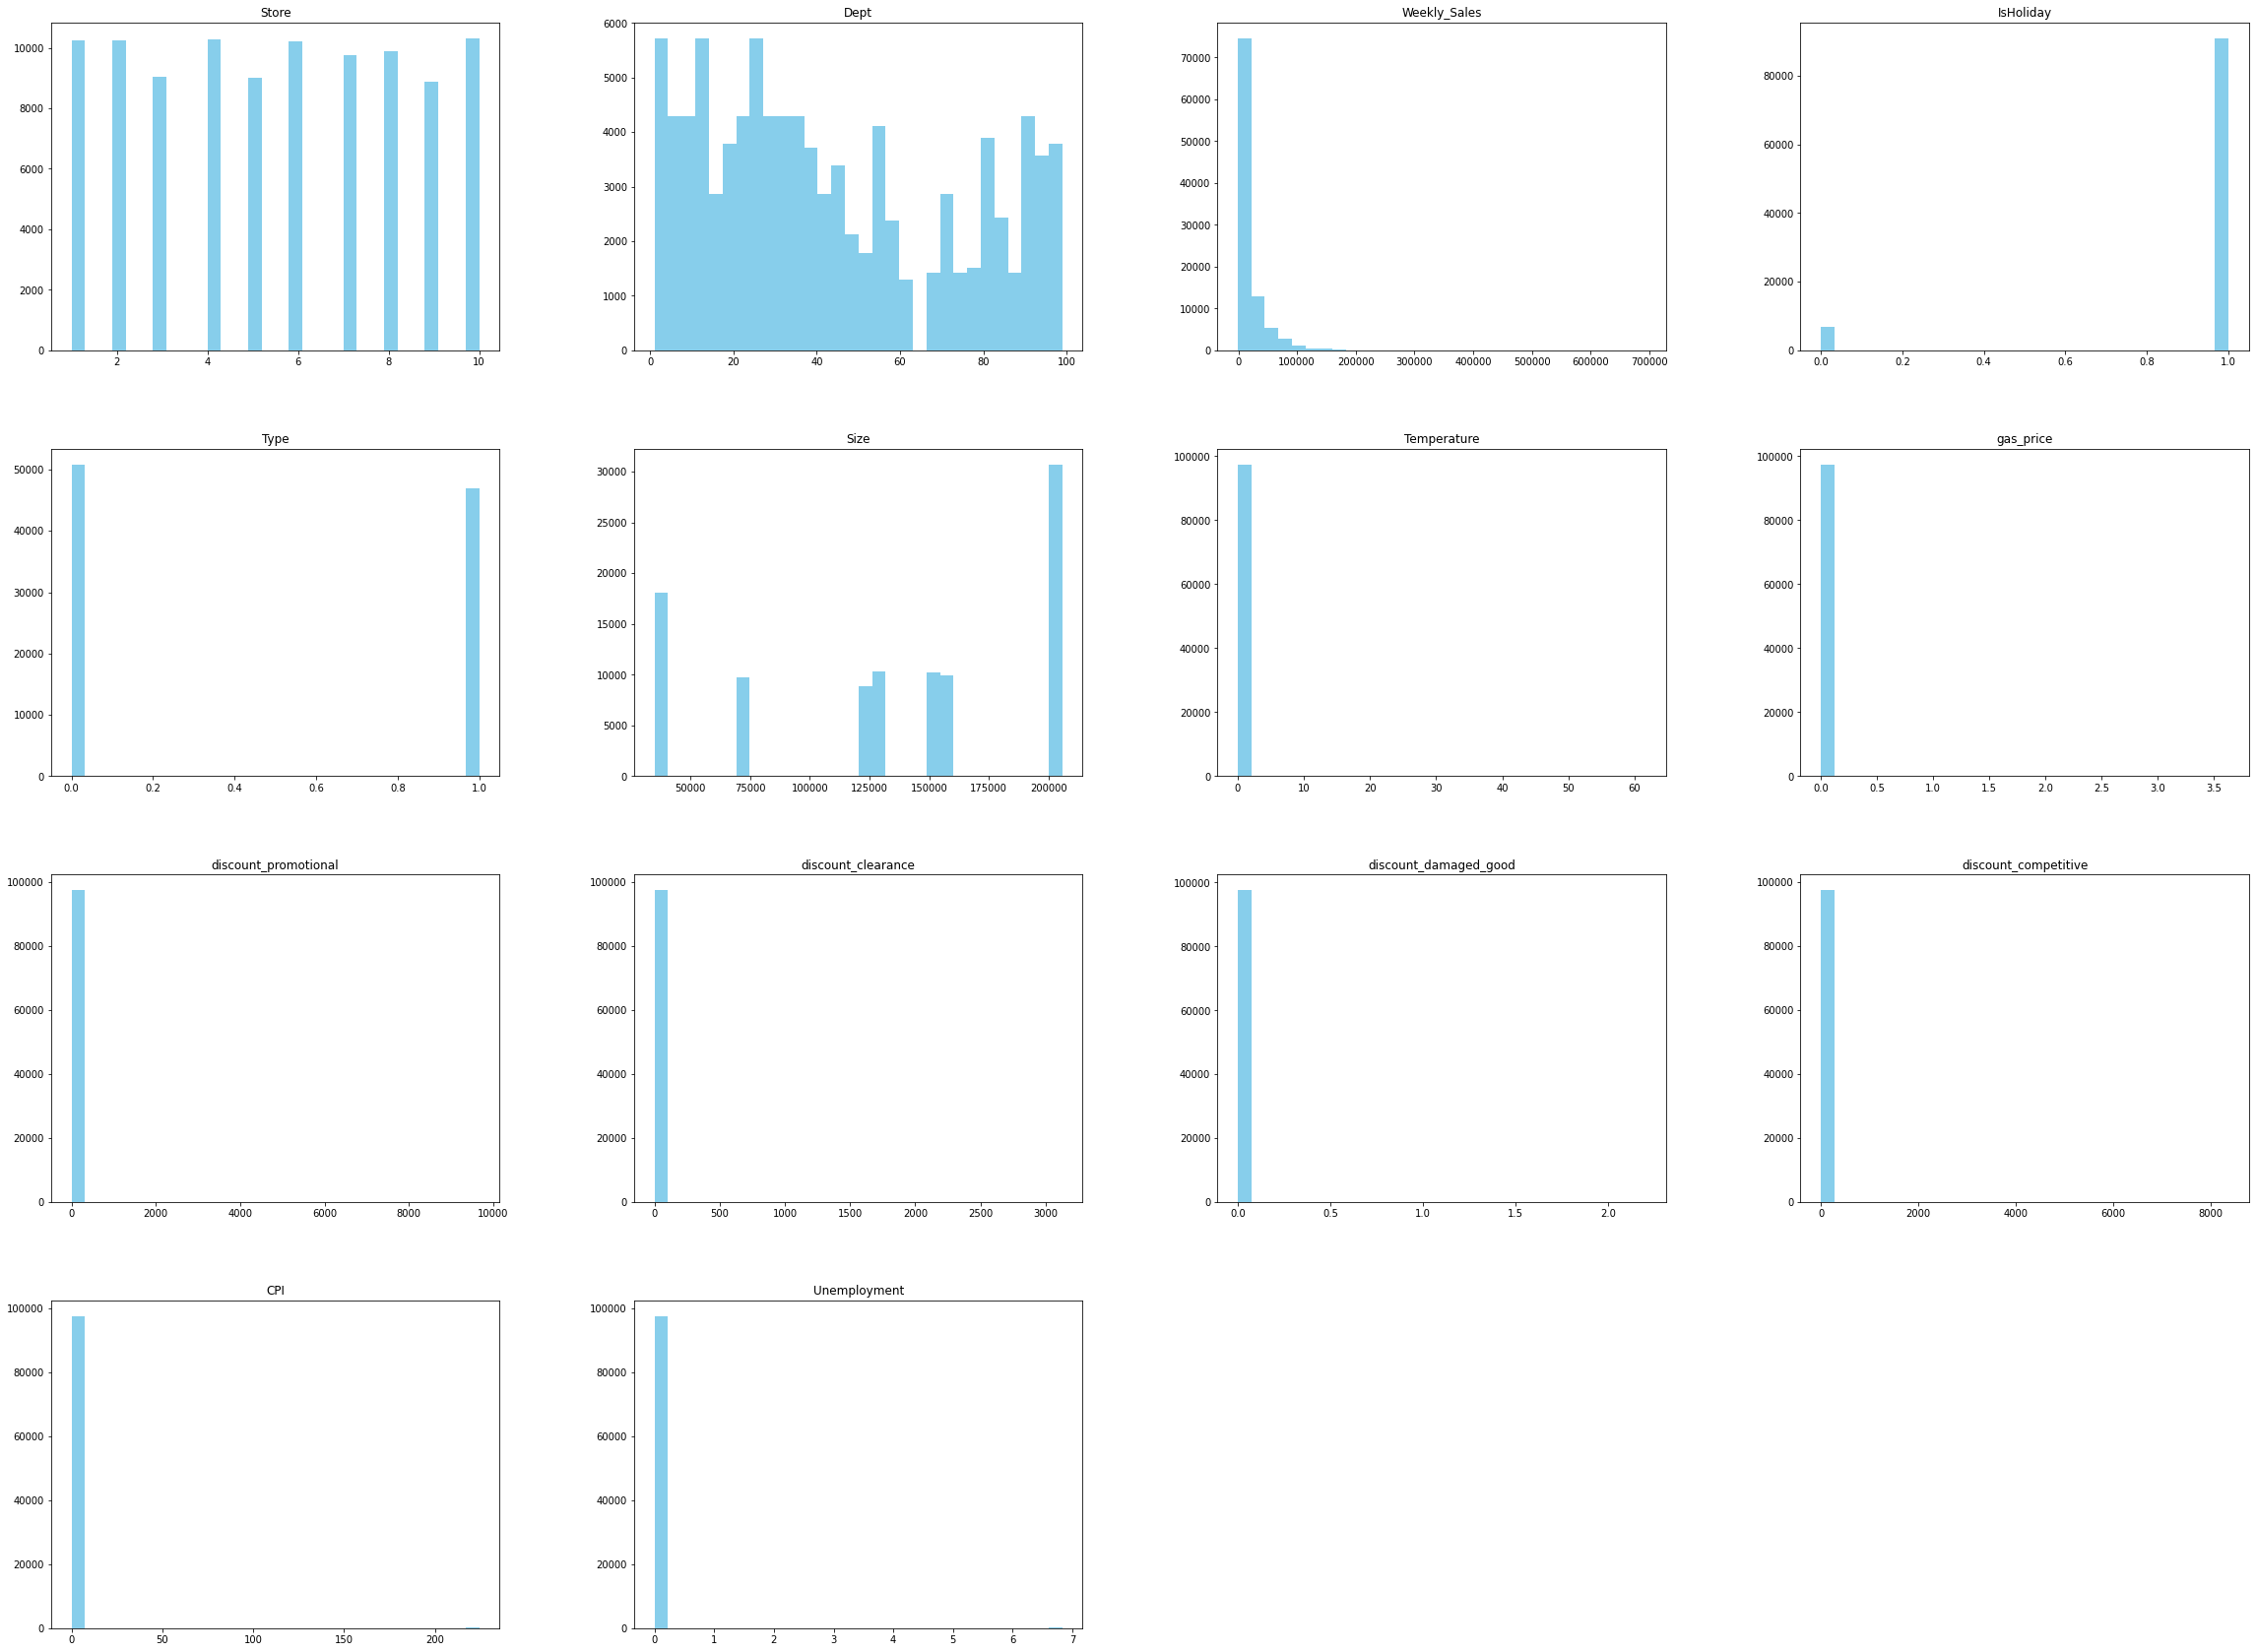

In [ ]:
corr_df.hist(bins = 30 , layout = (4,4), figsize = (40,30)  ,column = corr_df.columns[0:], color= "skyblue", grid = False)
plt.show()

In [ ]:
#taking first 2000 records for shap as google colab isn't supporting whole data

#corr_df = corr_df.drop(columns = ['CPI','Unemployment'])
train_shap = corr_df.head(2000);
y = train_shap['Weekly_Sales']
X = train_shap
X

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,gas_price,discount_promotional,discount_clearance,discount_damaged_good,discount_competitive,CPI,Unemployment
0,1,1,24924.50,1,0,151315,59.33,3.360,9667.50,268.29,0.60,8368.15,223.659114,6.833
1,1,1,46039.49,0,0,151315,51.65,3.409,8687.47,1594.87,2.20,2144.87,223.753643,6.833
2,1,1,41595.55,1,0,151315,52.39,3.510,2706.87,3128.74,1.88,2396.68,223.917015,6.833
3,1,1,19403.54,1,0,151315,60.12,3.555,6129.28,1802.84,0.00,301.48,224.132020,6.833
4,1,1,21827.90,1,0,151315,61.65,3.630,3552.58,601.32,0.00,2666.22,224.347025,6.833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,14,11596.10,1,0,151315,0.00,0.000,0.00,0.00,0.00,0.00,0.000000,0.000
1996,1,14,12193.80,1,0,151315,0.00,0.000,0.00,0.00,0.00,0.00,0.000000,0.000
1997,1,14,12037.66,1,0,151315,0.00,0.000,0.00,0.00,0.00,0.00,0.000000,0.000
1998,1,14,14381.21,1,0,151315,0.00,0.000,0.00,0.00,0.00,0.00,0.000000,0.000


In [ ]:

model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)

# Fit the Model

model.fit(X, y)


shap.initjs()


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)



i = 8
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

[07:13:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


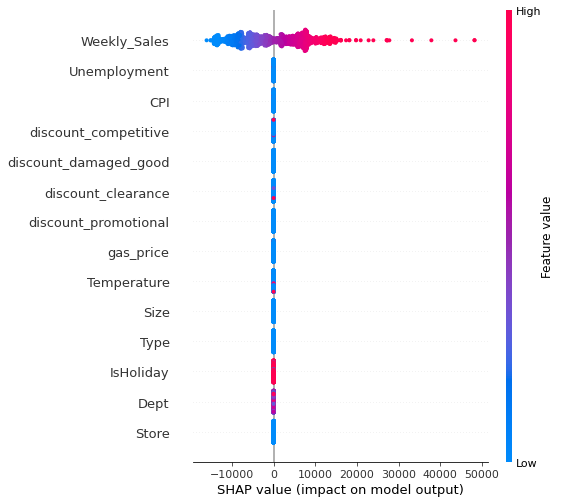

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

# Niti section ENDS

In [ ]:
first_ten_stores = train.loc[train['Store'] <= 10].copy()
first_ten_stores["datetime"] = pd.to_datetime(first_ten_stores["Date"])


In [ ]:
weekly_sales_ten_stores = first_ten_stores
weekly_sales_ten_stores['datetime'] = weekly_sales_ten_stores['datetime'].dt.strftime('%W')
weekly_sales_ten_stores = weekly_sales_ten_stores.groupby(['Dept'])['Weekly_Sales'].sum()
weekly_sales_ten_stores = weekly_sales_ten_stores.to_frame().reset_index()
weekly_sales_ten_stores_top35 = weekly_sales_ten_stores.sort_values(by='Weekly_Sales', ascending = False).head(35)
top35depts = weekly_sales_ten_stores_top35['Dept']
weekly_sales_ten_stores_top35

,Dept,Weekly_Sales
36,38,1.063737e+08
74,95,1.052439e+08
71,92,1.037589e+08
58,72,8.489495e+07
38,40,7.399350e+07
1,2,6.837999e+07
69,90,5.692374e+07
7,8,5.370687e+07
12,13,4.860091e+07
70,91,4.487316e+07


[Text(0, 0.5, 'Sales'), Text(0.5, 0, 'Week')]

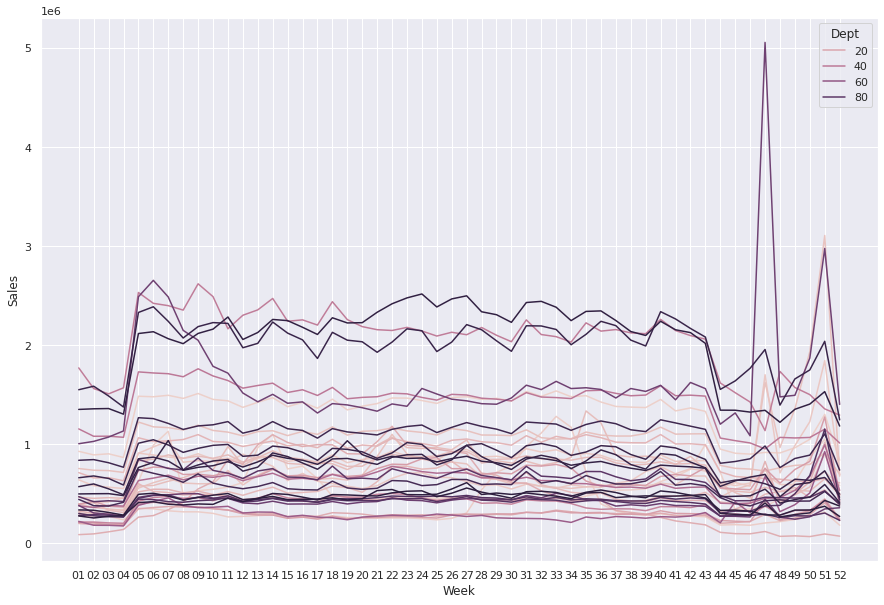

In [ ]:
first_ten_stores = train.loc[train['Store'] <= 10].copy()
first_ten_stores["datetime"] = pd.to_datetime(first_ten_stores["Date"])
weekly_sales_ten_stores = first_ten_stores
weekly_sales_ten_stores['datetime'] = weekly_sales_ten_stores['datetime'].dt.strftime('%W')
weekly_sales_ten_stores = weekly_sales_ten_stores.groupby(['Dept','datetime'])['Weekly_Sales'].sum()
weekly_sales_ten_stores = weekly_sales_ten_stores.to_frame().reset_index()
weekly_sales_ten_stores = weekly_sales_ten_stores.sort_values(by=['datetime', 'Dept'])
weekly_sales_ten_stores_top35 = weekly_sales_ten_stores[weekly_sales_ten_stores['Dept'].isin(top35depts.tolist())]
sns.set(rc={"figure.figsize":(15, 10)})
sns.lineplot(data=weekly_sales_ten_stores_top35, hue='Dept', x='datetime', y='Weekly_Sales').set(xlabel='Week', ylabel='Sales')

[Text(0, 0.5, 'Sales'), Text(0.5, 0, 'Month')]

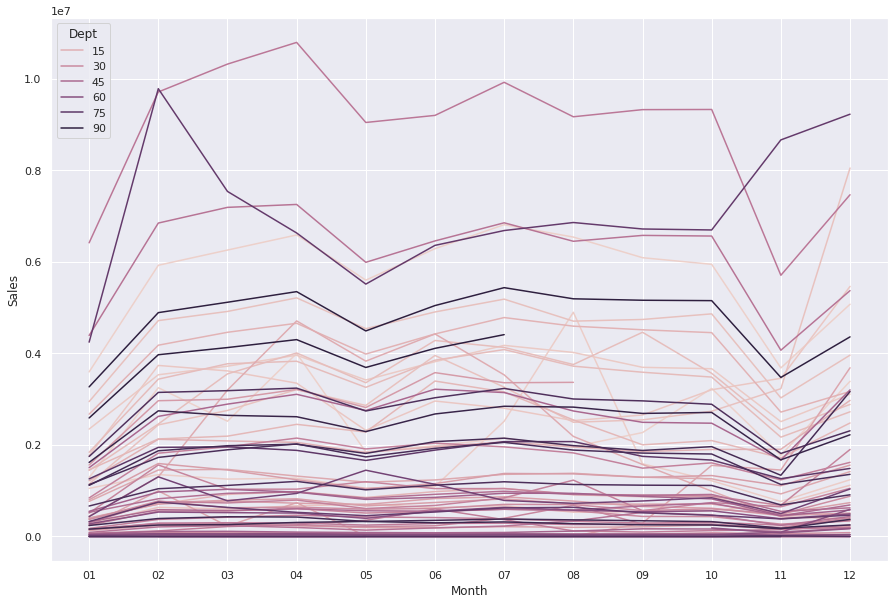

In [ ]:
first_ten_stores = train.loc[train['Store'] <= 10].copy()
first_ten_stores["datetime"] = pd.to_datetime(first_ten_stores["Date"])
monthly_sales_ten_stores = first_ten_stores.copy()
monthly_sales_ten_stores['datetime'] = monthly_sales_ten_stores['datetime'].dt.strftime('%m')
monthly_sales_ten_stores = monthly_sales_ten_stores.groupby(['Dept','datetime'])['Weekly_Sales'].sum()
monthly_sales_ten_stores = monthly_sales_ten_stores.to_frame().reset_index()
monthly_sales_ten_stores = monthly_sales_ten_stores.sort_values(by=['datetime', 'Dept'])
monthly_sales_ten_stores_top35 = monthly_sales_ten_stores[weekly_sales_ten_stores['Dept'].isin(top35depts.tolist())]
sns.set(rc={"figure.figsize":(15, 10)})
sns.lineplot(data=monthly_sales_ten_stores_top35, hue='Dept', x='datetime', y='Weekly_Sales').set(xlabel='Month', ylabel='Sales')

In [ ]:
first_ten_stores

,Store,Dept,Date,Weekly_Sales,IsHoliday,datetime
0,1,1,2010-02-05,24924.50,False,2010-02-05
1,1,1,2010-02-12,46039.49,True,2010-02-12
2,1,1,2010-02-19,41595.55,False,2010-02-19
3,1,1,2010-02-26,19403.54,False,2010-02-26
4,1,1,2010-03-05,21827.90,False,2010-03-05
...,...,...,...,...,...,...
97834,10,98,2012-09-28,22.34,False,2012-09-28
97835,10,98,2012-10-05,789.38,False,2012-10-05
97836,10,98,2012-10-12,477.24,False,2012-10-12
97837,10,98,2012-10-19,578.46,False,2012-10-19


In [ ]:
first_ten_stores = train.loc[train['Store'] <= 10].copy()
first_ten_stores["datetime"] = pd.to_datetime(first_ten_stores["Date"])
combined_stores["datetime"] = pd.to_datetime(combined_stores["Date"])

first_ten_merged = pd.merge(first_ten_stores,combined_stores,on=['Store','datetime'])
first_ten_merged = first_ten_merged.drop(columns=['IsHoliday_x','IsHoliday_y','Temperature','gas_price','Date_x','Date_y'])
first_ten_merged 

,Store,Dept,Weekly_Sales,datetime,discount_promotional,discount_clearance,discount_damaged_good,discount_competitive,CPI,Unemployment
0,1,1,24924.50,2010-02-05,9667.50,268.29,0.6,8368.15,223.659114,6.833
1,1,2,50605.27,2010-02-05,9667.50,268.29,0.6,8368.15,223.659114,6.833
2,1,3,13740.12,2010-02-05,9667.50,268.29,0.6,8368.15,223.659114,6.833
3,1,4,39954.04,2010-02-05,9667.50,268.29,0.6,8368.15,223.659114,6.833
4,1,5,32229.38,2010-02-05,9667.50,268.29,0.6,8368.15,223.659114,6.833
...,...,...,...,...,...,...,...,...,...,...
97834,10,94,795.76,2012-10-26,9657.93,63.30,100.0,1925.87,131.193097,6.943
97835,10,95,64643.03,2012-10-26,9657.93,63.30,100.0,1925.87,131.193097,6.943
97836,10,96,13966.23,2012-10-26,9657.93,63.30,100.0,1925.87,131.193097,6.943
97837,10,97,4785.28,2012-10-26,9657.93,63.30,100.0,1925.87,131.193097,6.943


In [ ]:
#co-relation
train_data_expanded
train_data_expanded.corr()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,gas_price,discount_promotional,discount_clearance,discount_damaged_good,discount_competitive,CPI,Unemployment
Store,1.000000,-0.010370,-0.067645,0.000211,0.468248,-0.136994,-0.094155,-0.094370,-0.086191,-0.077895,-0.066802,-0.071649,-0.094407,-0.094407
Dept,-0.010370,1.000000,0.114525,-0.000663,-0.034710,0.034246,0.000762,0.000756,0.000609,0.000528,0.000401,0.000565,0.000750,0.000749
Weekly_Sales,-0.067645,0.114525,1.000000,-0.014668,-0.222520,0.292869,0.010556,0.010647,0.010162,0.008681,0.008968,0.009168,0.010701,0.010704
IsHoliday,0.000211,-0.000663,-0.014668,1.000000,0.000089,0.000024,-0.025926,-0.029311,-0.045695,-0.028215,-0.066797,-0.011391,-0.030414,-0.030458
Type,0.468248,-0.034710,-0.222520,0.000089,1.000000,-0.841833,-0.058494,-0.058627,-0.053546,-0.048392,-0.041500,-0.044512,-0.058650,-0.058650
Size,-0.136994,0.034246,0.292869,0.000024,-0.841833,1.000000,0.017251,0.017290,0.015791,0.014271,0.012239,0.013127,0.017297,0.017297
Temperature,-0.094155,0.000762,0.010556,-0.025926,-0.058494,0.017251,1.000000,0.997839,0.909777,0.795075,0.654863,0.765258,0.997384,0.997338
gas_price,-0.094370,0.000756,0.010647,-0.029311,-0.058627,0.017290,0.997839,1.000000,0.903224,0.827323,0.697285,0.746757,0.999638,0.999607
discount_promotional,-0.086191,0.000609,0.010162,-0.045695,-0.053546,0.015791,0.909777,0.903224,1.000000,0.629744,0.672840,0.834045,0.912647,0.912974
discount_clearance,-0.077895,0.000528,0.008681,-0.028215,-0.048392,0.014271,0.795075,0.827323,0.629744,1.000000,0.808188,0.407174,0.825090,0.825098


In [ ]:
train_data_expanded.corr()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,gas_price,discount_promotional,discount_clearance,discount_damaged_good,discount_competitive,CPI,Unemployment
Store,1.000000,-0.010370,-0.067645,0.000211,0.468248,-0.136994,-0.094155,-0.094370,-0.086191,-0.077895,-0.066802,-0.071649,-0.094407,-0.094407
Dept,-0.010370,1.000000,0.114525,-0.000663,-0.034710,0.034246,0.000762,0.000756,0.000609,0.000528,0.000401,0.000565,0.000750,0.000749
Weekly_Sales,-0.067645,0.114525,1.000000,-0.014668,-0.222520,0.292869,0.010556,0.010647,0.010162,0.008681,0.008968,0.009168,0.010701,0.010704
IsHoliday,0.000211,-0.000663,-0.014668,1.000000,0.000089,0.000024,-0.025926,-0.029311,-0.045695,-0.028215,-0.066797,-0.011391,-0.030414,-0.030458
Type,0.468248,-0.034710,-0.222520,0.000089,1.000000,-0.841833,-0.058494,-0.058627,-0.053546,-0.048392,-0.041500,-0.044512,-0.058650,-0.058650
Size,-0.136994,0.034246,0.292869,0.000024,-0.841833,1.000000,0.017251,0.017290,0.015791,0.014271,0.012239,0.013127,0.017297,0.017297
Temperature,-0.094155,0.000762,0.010556,-0.025926,-0.058494,0.017251,1.000000,0.997839,0.909777,0.795075,0.654863,0.765258,0.997384,0.997338
gas_price,-0.094370,0.000756,0.010647,-0.029311,-0.058627,0.017290,0.997839,1.000000,0.903224,0.827323,0.697285,0.746757,0.999638,0.999607
discount_promotional,-0.086191,0.000609,0.010162,-0.045695,-0.053546,0.015791,0.909777,0.903224,1.000000,0.629744,0.672840,0.834045,0.912647,0.912974
discount_clearance,-0.077895,0.000528,0.008681,-0.028215,-0.048392,0.014271,0.795075,0.827323,0.629744,1.000000,0.808188,0.407174,0.825090,0.825098


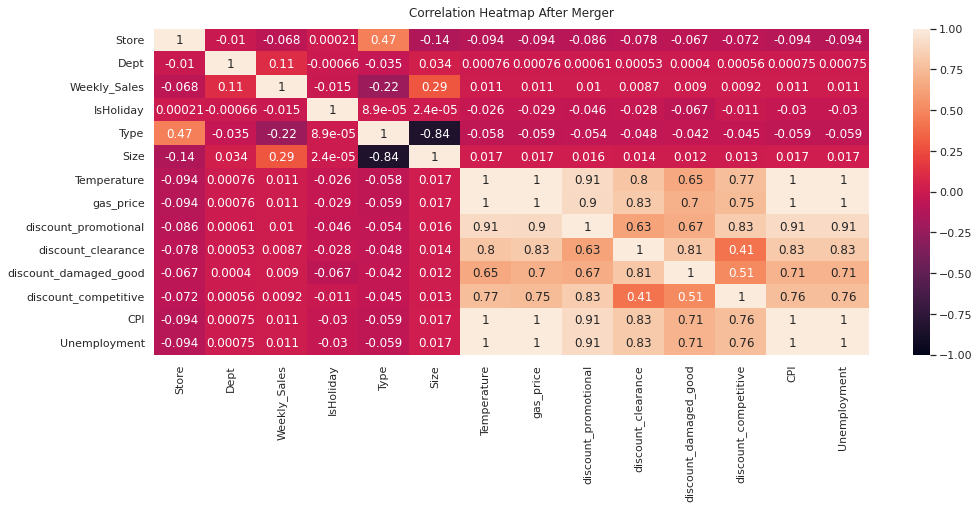

In [ ]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(train_data_expanded.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap After Merger', fontdict={'fontsize':12}, pad=12);

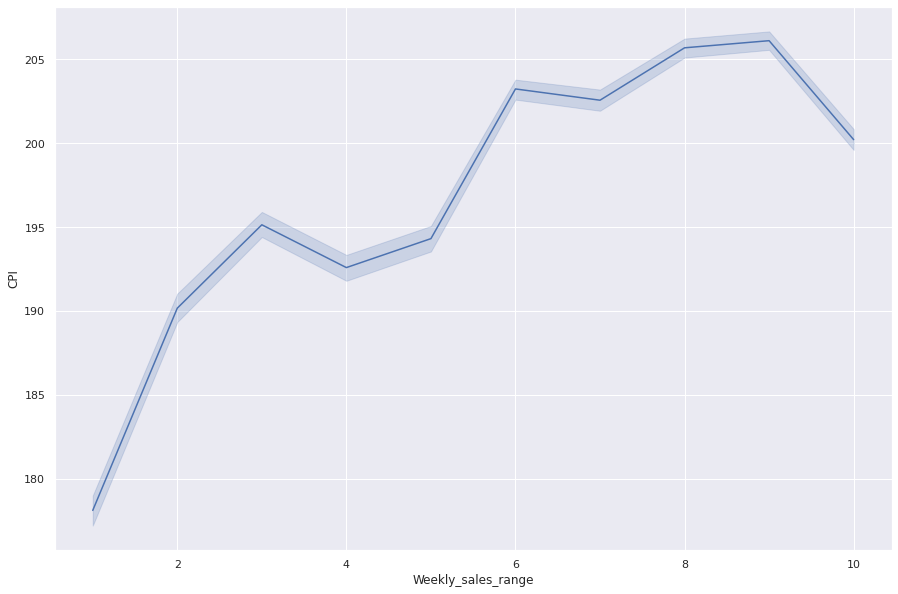

In [ ]:
sales_range =  range(10, 0, -1)
sales_quartiles = pd.qcut(first_ten_merged['Weekly_Sales'], 10, labels=sales_range)
first_ten_merged = first_ten_merged.assign(Weekly_sales_range = sales_quartiles.values)

sns.lineplot(data=first_ten_merged, x='Weekly_sales_range', y='CPI')

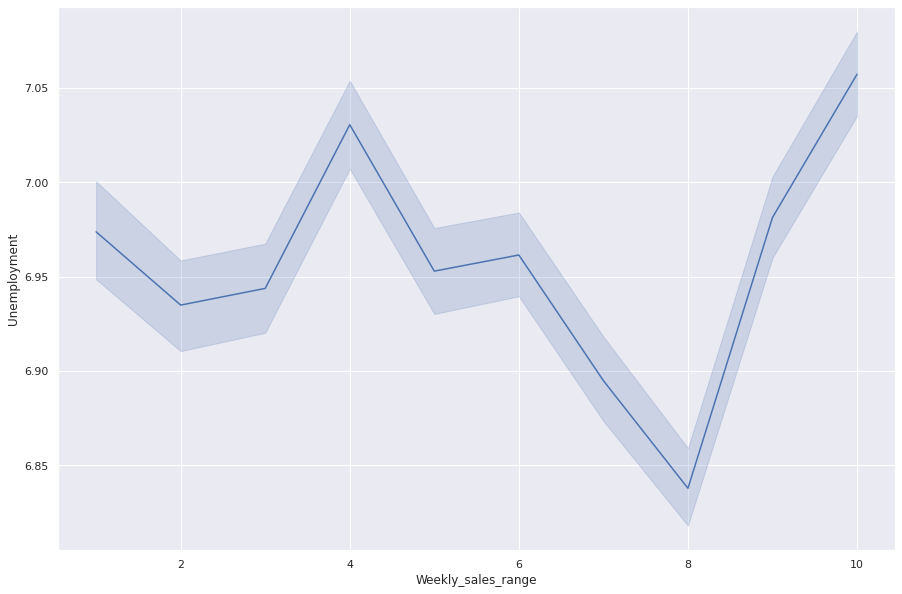

In [ ]:
sns.lineplot(data=first_ten_merged, x='Weekly_sales_range', y='Unemployment')

# Siddharth section END 

In [ ]:
# Vishal
squareFeet = stores
store = combined_stores
df = train



In [ ]:
# Top 35 stores aggregate the sum
group = df.groupby(['Store'], sort=False).agg({'Weekly_Sales': 'sum'})
group = group.head(35)

# Calculate Sales per square feet for all stores
sales_per_sqft = pd.merge(group, squareFeet, on=['Store'])
sales_per_sqft['Sales_per_sqft'] = sales_per_sqft['Weekly_Sales'] // sales_per_sqft['Size']

# Top 30% best performing stores
top_30 = sales_per_sqft.sort_values('Sales_per_sqft', ascending=False)
top_30_stores = top_30.head(11)
print(top_30_stores)

# Bottom 30% performing stores
bottom_30 = sales_per_sqft.sort_values('Sales_per_sqft')
bottom_30_stores = bottom_30.head(11)

    Store  Weekly_Sales Type    Size  Sales_per_sqft
9      10  2.716177e+08    B  126512          2146.0
22     23  1.987506e+08    B  114533          1735.0
2       3  5.758674e+07    B   37392          1540.0
19     20  3.013978e+08    A  203742          1479.0
0       1  2.224028e+08    A  151315          1469.0
29     30  6.271689e+07    C   42988          1458.0
3       4  2.995440e+08    A  205863          1455.0
13     14  2.889999e+08    A  200898          1438.0
16     17  1.277821e+08    B   93188          1371.0
1       2  2.753824e+08    A  202307          1361.0
12     13  2.865177e+08    A  219622          1304.0


In [ ]:
# Merge Store data with Sales per square feet data
top_store = store
top_store = top_store[top_store['Store'].isin(top_30_stores.loc[:,"Store"])]
merge_top_value = pd.merge(top_store, top_30, on=['Store'])
print(merge_top_value)

     Store                 Date  IsHoliday  Temperature  gas_price  \
0        1             2/5/2010      False        59.33      3.360   
1        1            2/12/2010       True        51.65      3.409   
2        1            2/19/2010      False        52.39      3.510   
3        1            2/26/2010      False        60.12      3.555   
4        1             3/5/2010      False        61.65      3.630   
..     ...                  ...        ...          ...        ...   
905     10  2013-06-28 00:00:00      False        90.28      3.781   
906     10  2013-07-05 00:00:00      False        93.54      3.753   
907     10  2013-07-12 00:00:00      False        87.18      3.737   
908     10  2013-07-19 00:00:00      False        87.09      3.823   
909     10  2013-07-26 00:00:00      False        83.32      3.865   

     discount_promotional  discount_clearance  discount_damaged_good  \
0                 9667.50              268.29                   0.60   
1              

In [ ]:
# Fetch the columns of discount and sales of top 30% the store
group = merge_top_value[['Store', 'discount_clearance', 'discount_promotional', 'discount_damaged_good', 'discount_competitive', 'Weekly_Sales']]
print(group.isna().any())

print("\nAfter cleaning the values\n")
  
imputer = KNNImputer(n_neighbors=10)
group = pd.DataFrame(imputer.fit_transform(group),columns = group.columns)   
print(group.isna().any())


Store                    False
discount_clearance        True
discount_promotional      True
discount_damaged_good     True
discount_competitive      True
Weekly_Sales             False
dtype: bool

After cleaning the values

Store                    False
discount_clearance       False
discount_promotional     False
discount_damaged_good    False
discount_competitive     False
Weekly_Sales             False
dtype: bool


Co-relation of discount with top 30% sales of the stores


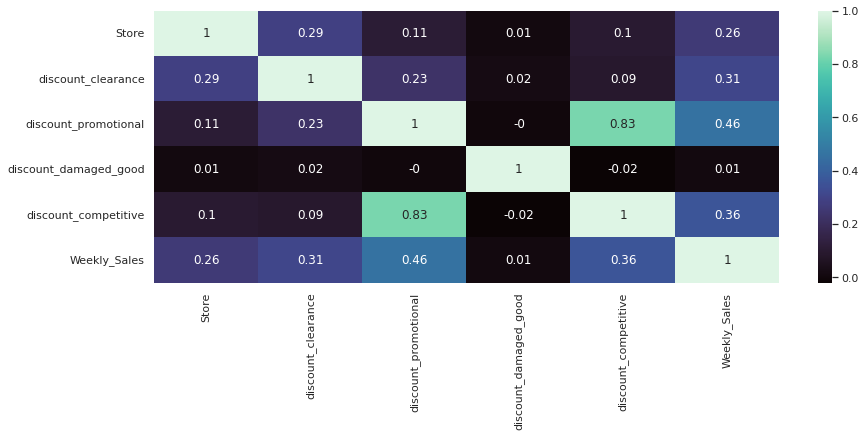

In [ ]:
# Draw correlation 
print("Co-relation of discount with top 30% sales of the stores")
import seaborn as sns
store_corr= group.corr()

plt.figure(figsize = (14,5))
sns.heatmap(round(store_corr,2),annot=True,cmap = 'mako')


In [ ]:
bottom_store = store
bottom_store = bottom_store[bottom_store['Store'].isin(bottom_30_stores.loc[:,"Store"])]
merge_bottom_value = pd.merge(bottom_store, bottom_30, on=['Store'])
merge_bottom_value.head(20)

,Store,Date,IsHoliday,Temperature,gas_price,discount_promotional,discount_clearance,discount_damaged_good,discount_competitive,CPI,Unemployment,datetime,Weekly_Sales,Type,Size,Sales_per_sqft
0,8,2010-02-05 00:00:00,False,34.14,2.572,NaN,NaN,NaN,NaN,214.471451,6.299,2010-02-05,1.299512e+08,A,155078,837.0
1,8,2010-02-12 00:00:00,True,33.34,2.548,NaN,NaN,NaN,NaN,214.621419,6.299,2010-02-12,1.299512e+08,A,155078,837.0
2,8,2010-02-19 00:00:00,False,39.10,2.514,NaN,NaN,NaN,NaN,214.666488,6.299,2010-02-19,1.299512e+08,A,155078,837.0
3,8,2010-02-26 00:00:00,False,37.91,2.561,NaN,NaN,NaN,NaN,214.694074,6.299,2010-02-26,1.299512e+08,A,155078,837.0
4,8,2010-03-05 00:00:00,False,45.64,2.625,NaN,NaN,NaN,NaN,214.721659,6.299,2010-03-05,1.299512e+08,A,155078,837.0
5,8,2010-03-12 00:00:00,False,49.76,2.667,NaN,NaN,NaN,NaN,214.749245,6.299,2010-03-12,1.299512e+08,A,155078,837.0
6,8,2010-03-19 00:00:00,False,47.26,2.720,NaN,NaN,NaN,NaN,214.576495,6.299,2010-03-19,1.299512e+08,A,155078,837.0
7,8,2010-03-26 00:00:00,False,46.51,2.732,NaN,NaN,NaN,NaN,214.370357,6.299,2010-03-26,1.299512e+08,A,155078,837.0
8,8,2010-04-02 00:00:00,False,60.18,2.719,NaN,NaN,NaN,NaN,214.164218,6.290,2010-04-02,1.299512e+08,A,155078,837.0
9,8,2010-04-09 00:00:00,False,59.25,2.770,NaN,NaN,NaN,NaN,213.958079,6.290,2010-04-09,1.299512e+08,A,155078,837.0


In [ ]:
# Fetch the columns of discount and sales of bottom 30% the store
bottom_group = merge_bottom_value[['Store', 'discount_clearance', 'discount_promotional', 'discount_damaged_good', 'discount_competitive', 'Weekly_Sales']]
print(bottom_group.isna().any())

print("\nAfter cleaning the values\n")
  
imputer = KNNImputer(n_neighbors=10)
bottom_group = pd.DataFrame(imputer.fit_transform(bottom_group),columns = bottom_group.columns)   

print(bottom_group.isna().any())

Store                    False
discount_clearance        True
discount_promotional      True
discount_damaged_good     True
discount_competitive      True
Weekly_Sales             False
dtype: bool

After cleaning the values

Store                    False
discount_clearance       False
discount_promotional     False
discount_damaged_good    False
discount_competitive     False
Weekly_Sales             False
dtype: bool


Co-relation of discount with bottom 30% sales of the stores


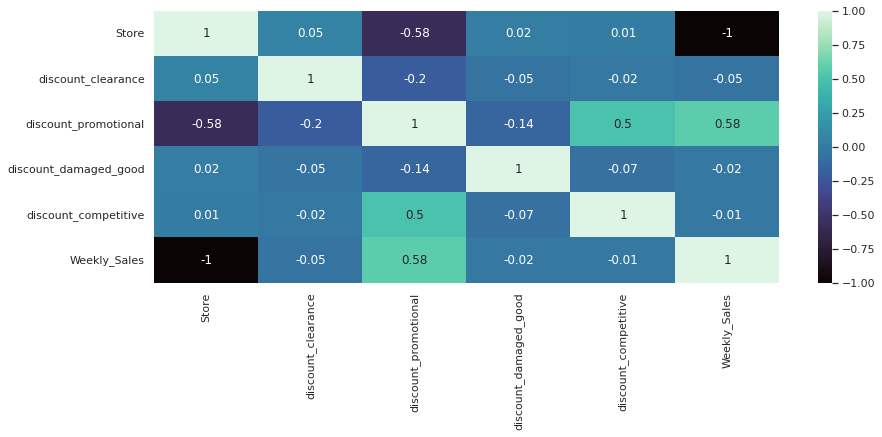

In [ ]:
# Draw correlation 
print("Co-relation of discount with bottom 30% sales of the stores")
bottom_store_corr= bottom_group.corr()

plt.figure(figsize = (14,5))
sns.heatmap(round(bottom_store_corr,2),annot=True,cmap = 'mako')

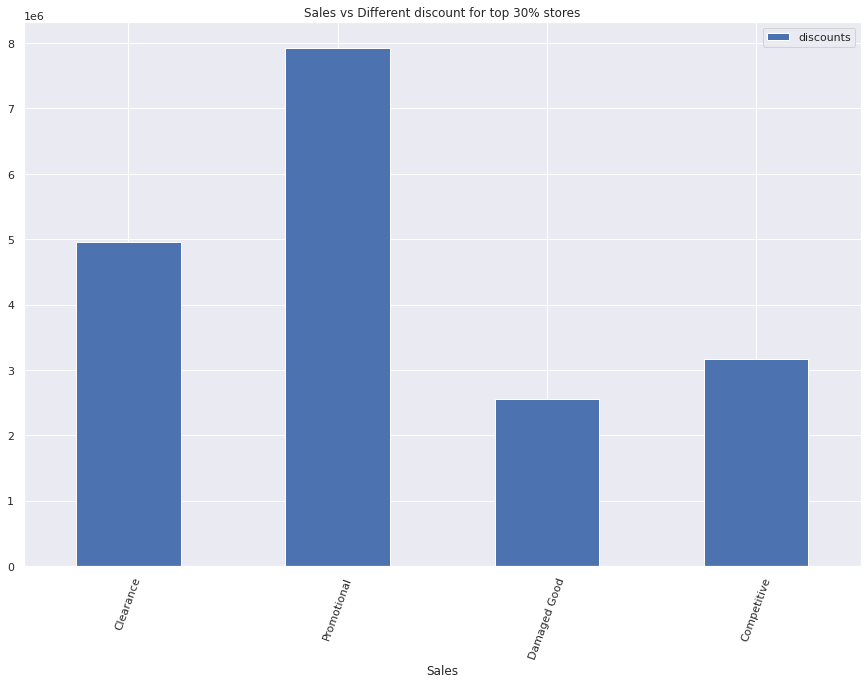

In [ ]:
discount_clearance = group["discount_clearance"].sum()
discount_promotional = group["discount_promotional"].sum()
discount_damaged_good = group["discount_damaged_good"].sum()
discount_competitive = group["discount_competitive"].sum()

data = {"Sales":["Clearance", "Promotional", "Damaged Good", "Competitive"],
      "discounts":[discount_clearance,discount_promotional,discount_damaged_good, discount_competitive]
        };

dataFrame = pd.DataFrame(data=data);
# Draw a vertical bar chart
dataFrame.plot.bar(x="Sales", y="discounts", rot=70, title="Sales vs Different discount for top 30% stores");
plt.show(block=True);

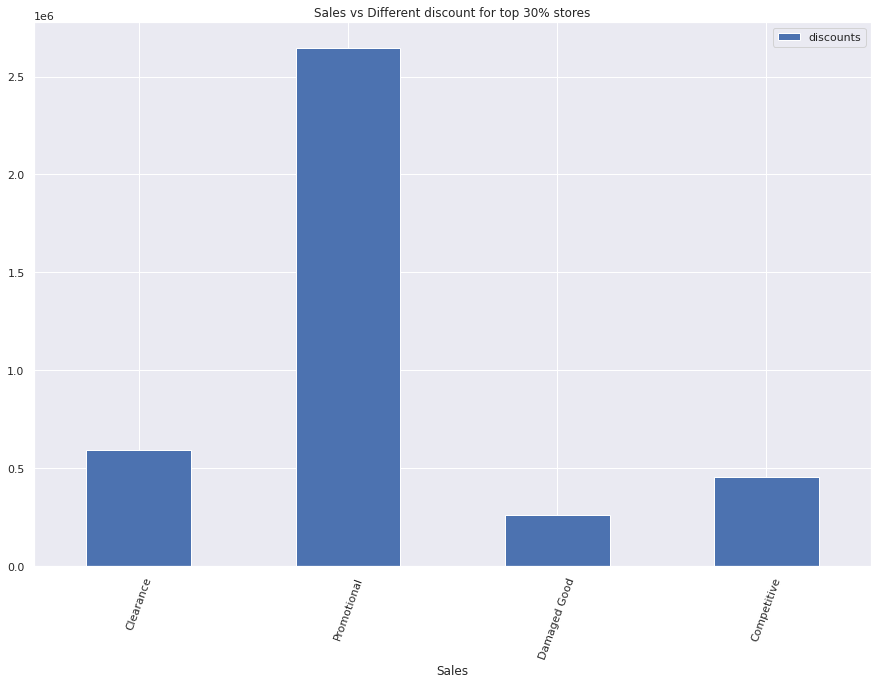

In [ ]:
discount_clearance = bottom_group["discount_clearance"].sum()
discount_promotional = bottom_group["discount_promotional"].sum()
discount_damaged_good = bottom_group["discount_damaged_good"].sum()
discount_competitive = bottom_group["discount_competitive"].sum()

data = {"Sales":["Clearance", "Promotional", "Damaged Good", "Competitive"],
      "discounts":[discount_clearance,discount_promotional,discount_damaged_good, discount_competitive]
        };

dataFrame = pd.DataFrame(data=data);
# Draw a vertical bar chart
dataFrame.plot.bar(x="Sales", y="discounts", rot=70, title="Sales vs Different discount for top 30% stores");
plt.show(block=True);

# Vishal End

In [ ]:
#Kashmira
combined_stores["Date"] = pd.to_datetime(combined_stores["Date"])
train_35 = train.loc[train['Store'] <= 35].copy()
train_35["Date"] = pd.to_datetime(train_35["Date"])


In [ ]:
final_merged = train_35.merge(combined_stores,on=['Store','Date'], how='left')

final_merged = final_merged.drop(columns=['IsHoliday_y','discount_promotional','discount_clearance','discount_damaged_good','discount_competitive', 'CPI', 'Unemployment'])
final_merged = final_merged.loc[final_merged['Dept'] <= 10].copy()
final_merged.tail(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,gas_price,datetime
332179,35,10,2012-08-24,13727.58,False,NaN,NaN,NaT
332180,35,10,2012-08-31,13173.20,False,NaN,NaN,NaT
332181,35,10,2012-09-07,14630.52,True,NaN,NaN,NaT
332182,35,10,2012-09-14,12744.10,False,NaN,NaN,NaT
332183,35,10,2012-09-21,14567.14,False,NaN,NaN,NaT
332184,35,10,2012-09-28,14057.75,False,NaN,NaN,NaT
332185,35,10,2012-10-05,14270.55,False,NaN,NaN,NaT
332186,35,10,2012-10-12,14821.31,False,NaN,NaN,NaT
332187,35,10,2012-10-19,15732.96,False,NaN,NaN,NaT
332188,35,10,2012-10-26,15071.72,False,NaN,NaN,NaT


In [ ]:
sales_range =  range(10, 0, -1)
sales_quartiles = pd.qcut(final_merged['Weekly_Sales'], 10, labels=sales_range)
final_merged = final_merged.assign(Weekly_sales_range = sales_quartiles.values)

final_merged['IsHoliday_x'].replace([False, True],
                        [0, 1], inplace=True)
final_merged.tail(150)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,gas_price,datetime,Weekly_sales_range
332039,35,9,2012-09-14,10720.92,0,NaN,NaN,NaT,8
332040,35,9,2012-09-21,9283.39,0,NaN,NaN,NaT,8
332041,35,9,2012-09-28,9909.01,0,NaN,NaN,NaT,8
332042,35,9,2012-10-05,10399.06,0,NaN,NaN,NaT,8
332043,35,9,2012-10-12,9649.81,0,NaN,NaN,NaT,8
...,...,...,...,...,...,...,...,...,...
332184,35,10,2012-09-28,14057.75,0,NaN,NaN,NaT,7
332185,35,10,2012-10-05,14270.55,0,NaN,NaN,NaT,7
332186,35,10,2012-10-12,14821.31,0,NaN,NaN,NaT,7
332187,35,10,2012-10-19,15732.96,0,NaN,NaN,NaT,6


In [ ]:
dept_mean_sales= final_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].mean().to_frame()
dept_mean_temp = final_merged.groupby(['Store', 'Dept'])['Temperature'].mean().to_frame()
dept_mean_gas = final_merged.groupby(['Store', 'Dept'])['gas_price'].mean().to_frame()
finalX = dept_mean_sales.merge(dept_mean_temp,on=['Store','Dept'], how='left')
finalX = finalX.merge(dept_mean_gas,on=['Store','Dept'], how='left')
finalX.tail(10)

Weekly_Sales  Temperature  gas_price
Store Dept                                      
35    1     17082.647902          NaN        NaN
      2     45578.456224          NaN        NaN
      3     14308.382797          NaN        NaN
      4     19495.631119          NaN        NaN
      5     24858.433706          NaN        NaN
      6      7256.417133          NaN        NaN
      7     30267.589790          NaN        NaN
      8     18416.401678          NaN        NaN
      9     15657.032937          NaN        NaN
      10    14818.443706          NaN        NaN

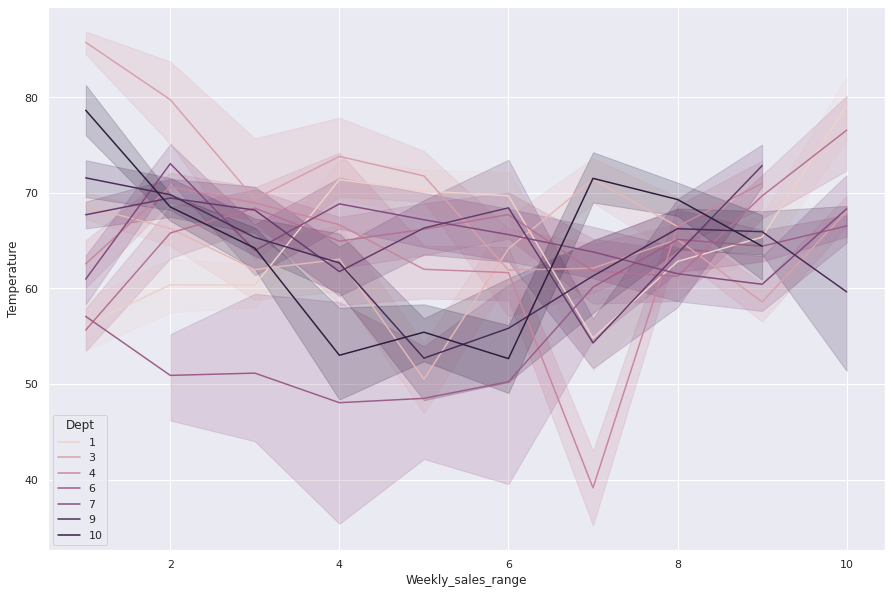

In [ ]:
import seaborn as sns
sns.lineplot(data=final_merged, hue='Dept', x='Weekly_sales_range', y='Temperature')

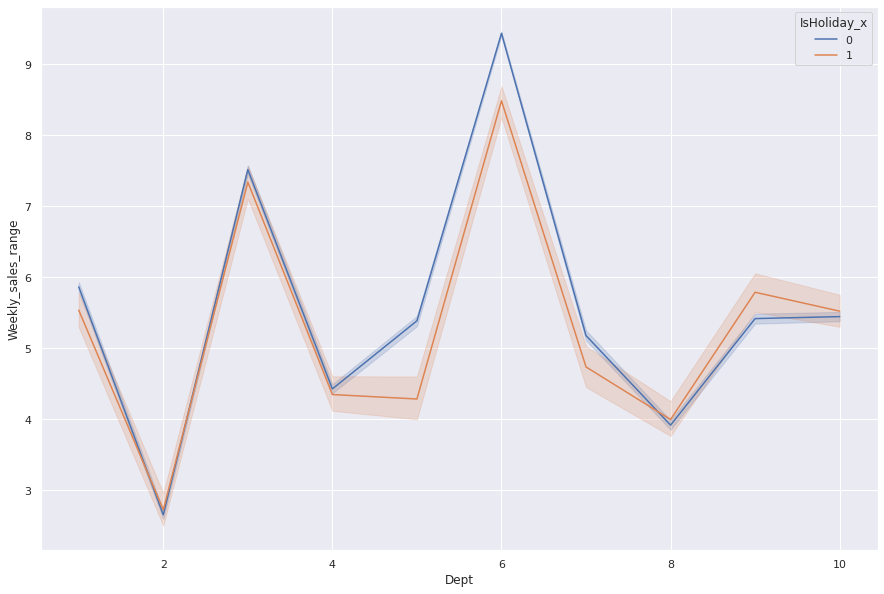

In [ ]:
sns.lineplot(data=final_merged, hue='IsHoliday_x', x='Dept', y='Weekly_sales_range').invert_yaxis()

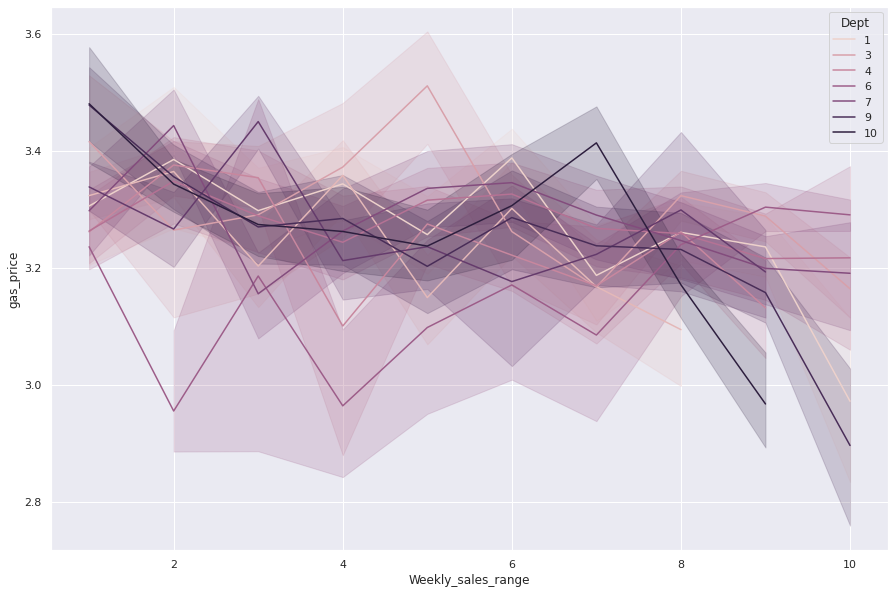

In [ ]:
sns.lineplot(data=final_merged, hue='Dept', x='Weekly_sales_range', y='gas_price')